In [108]:
from pathlib import Path
home = str(Path.home())
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import os 

# Create the directory if it doesn't exist
current_directory = os.getcwd()
output_dir = os.path.join(current_directory, "output_dir")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


def get_df_reg_class(path_reg, path_class):
    """
    Given the paths to the prediction values, reads in the file and formats it in df. 
    Renames the column names to "reg" and "class" for the corresponding prediction values
    """
    df_reg = pd.read_csv(path_reg, sep = "\t")
    df_reg["reg"] = df_reg["mean"]

    df_class = pd.read_csv(path_class, sep = "\t")
    df_class["class"] = df_class["pred_activity"]

    return df_reg, df_class


def combine_reg_class_color(df_reg, df_class, low_threshold):
    """
    Combines the df_reg and df_class. Given the column name "reg" for regression predictions, "class" for classification predictions.
    The merge happens through "compound" between the two dfs. 
    Some compounds are discarded in classification dataset, so these are given NaN values under "class" column. 
    There is a "color" column. The colors are as follows:
        black -> discarded data in classification (between low and high threshold)
        blue -> binders
        orange -> nonbinders
    """
    choices = ['black', 'blue', 'orange'] # to be used later in the code

    high_threshold = low_threshold+1

    df = pd.merge(df_reg, df_class, on='compound', how='left')
    df["exp"]=df["exp_mean_x"] # assumes that both df_reg and df_class have "exp_mean" as a column, and the merge leads to exp_mean_x for df_reg
    df = df[["compound", "exp", "reg", "class"]] # exp is the regression experimental value

    conditions = [
        (df['exp'] >= low_threshold) & (df['exp'] <= high_threshold),  # Condition for 'black'
        df['class'] == 1,                      # Condition for 'blue'
        df['class'] == 0                       # Condition for 'orange'
    ]

    df['color'] = np.select(conditions, choices, default=0)

    assert df.loc[df['color'] == 'black', 'class'].isna().all(), "Some 'black' rows have non-NaN values in 'class'."
    #assert len(df["reg"]) == len(df["class"]) + df[df["color"] == "black"].shape[0], "Row count mismatch!"
    assert len(df["reg"]) == len(df["class"].dropna()) + df[df["color"] == "black"].shape[0], \
        f"Row count mismatch! reg: {len(df['reg'])}, class: {len(df['class'].dropna())}, black count: {df[df['color'] == 'black'].shape[0]}"

    return df


def plot_predictions(df, low_threshold, xy_min, xy_max, plot_size, save2png = False):
    '''
    "mean" corresponds to predictions
    "exp_mean" corresponds to experimental values from ChEMBL

    '''
    
    # Scatter plot
    x_column = "exp"
    y_column = "reg"
    high_threshold = low_threshold+1


    # Scatter plot
    plt.figure(figsize=(plot_size, plot_size))
    # plt.scatter(df[x_column], df[y_column], color=colors,  marker='d', s = 15, alpha=0.6)
    plt.scatter(df[x_column], df[y_column], c=df["color"], marker='d', s=15, alpha=0.6)


    # Labels and title
    plt.xlabel(x_column)
    plt.ylabel(y_column)


    plt.plot([xy_min, low_threshold], [low_threshold, low_threshold], color='red', linestyle='-', linewidth=1)  
    plt.plot([low_threshold, low_threshold], [low_threshold, xy_min], color='red', linestyle='-', linewidth=1)  

    plt.plot([xy_min, high_threshold], [high_threshold, high_threshold], color='red', linestyle='-', linewidth=1)  
    plt.plot([high_threshold, high_threshold], [high_threshold, xy_min], color='red', linestyle='-', linewidth=1)  

    plt.xticks(np.arange(int(xy_min), int(xy_max) + 1, 1))
    plt.yticks(np.arange(int(xy_min), int(xy_max) + 1, 1))
    
    plt.xlim(xy_min, xy_max)  # Set x-axis limits
    plt.ylim(xy_min, xy_max)  # Set y-axis limits
    plt.tick_params(axis='both', which='both', top=True, right=True)
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

    if save2png:
        plt.xlabel('')  # Remove x-axis label
        plt.ylabel('')  # Remove y-axis label
        # Set the ticks and remove tick labels
        plt.xticks(np.arange(int(xy_min), int(xy_max) + 1, 1), labels=[])  # Remove x-axis tick labels but keep ticks
        plt.yticks(np.arange(int(xy_min), int(xy_max) + 1, 1), labels=[])  # Remove y-axis tick labels but keep ticks
        plt.xlim(xy_min, xy_max)  # Set x-axis limits
        plt.ylim(xy_min, xy_max)  # Set y-axis limits
        # plt.tick_params(axis='both', which='both', direction='in', length=6)
        plt.savefig(save2png, bbox_inches='tight', transparent = True, format='png', dpi=300)  # You can adjust the dpi for higher or lower quality
        # plt.show()
        plt.close()
    else:
        # print minimum and maximum to make sure you adjust the axis correctly
        print("min", min(min(df["reg"]), min(df["exp"])))
        print("max", max(max(df["reg"]), max(df["exp"])))
        plt.show()

In [109]:
def plot_model(path, model, method, save2png):
    # reformat plot sizes and boundaries based on models used
    if model == "models__ratio_D2D3":
        xy_min = -2.5
        xy_max = 3.5
        plot_size = 3 
        low_threshold = 0
    elif model == "models_D3":
        xy_min = 3.5
        xy_max = 10.5
        plot_size = 3 
        low_threshold = 6.16
    elif model == "models_D2":
        xy_min = 3.5
        xy_max = 10.5
        plot_size = 3 
        low_threshold = 5.82

    # filenames are different between dnn and xgb/rf
    if method == "dnn":
        filename_reg = "pred_splits"
        filename_class = "pred_splits"
    else:
        filename_reg = "pred_splits_val0"
        filename_class = "pred_splits_val_class0"
    path_reg = path+f"{model}/model_0/pred_reg_{method}_0.00/{filename_reg}"
    path_class = path+f"{model}/model_0/pred_class_{method}_0.00/{filename_class}"

    # get the df then plot results
    df_reg, df_class = get_df_reg_class(path_reg, path_class)
    df = combine_reg_class_color(df_reg, df_class, low_threshold)
    plot_predictions(df, low_threshold, xy_min, xy_max, plot_size)
    plot_predictions(df, low_threshold, xy_min, xy_max, plot_size, save2png = save2png)

    return df


def binder_ratio(df, threshold):
    _df = df[df["color"] != "black"]
    binders = _df[_df["exp"] > threshold]
    blue = binders[binders["color"] == "blue"]
    print(len(binders), len(blue))

def nonbinder_ratio(df, threshold):
    _df = df[df["color"] != "black"]
    nonbinders = _df[_df["exp"] < threshold]
    orange = nonbinders[nonbinders["color"] == "orange"]
    print(len(nonbinders), len(orange))



min -2.28
max 3.35


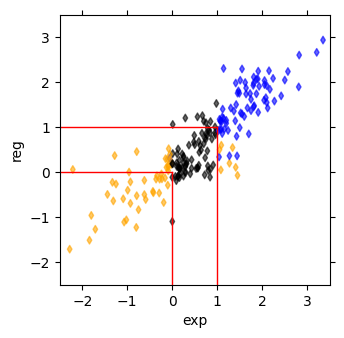

78 71
46 45
min -2.28
max 3.35


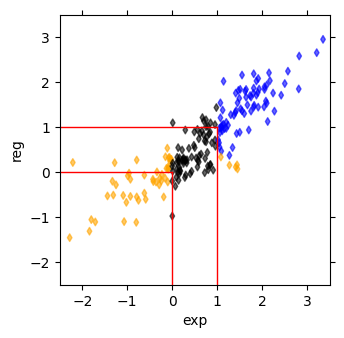

78 73
46 46
min -2.28
max 3.35


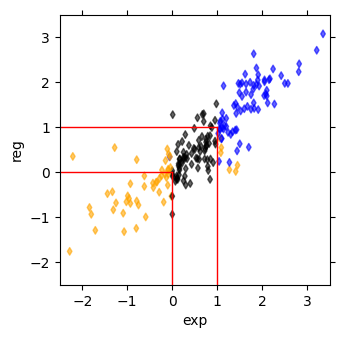

In [110]:
path = home+"/repositories/ai-DR/selectivity_models/models_C33_200/"
model = "models__ratio_D2D3"

method = "xgb"
save2png = "output_dir/D3_selective_xgb.png"
df1 = plot_model(path, model, method, save2png)
binder_ratio(df1, 1)
nonbinder_ratio(df1, 0)

method = "rf"
save2png = "output_dir/D3_selective_rf.png"
df2 = plot_model(path, model, method, save2png)
binder_ratio(df2, 1)
nonbinder_ratio(df2, 0)

method = "dnn"
save2png = "output_dir/D3_selective_dnn.png"
df3 = plot_model(path, model, method, save2png)

min 4.817703723907471
max 10.34


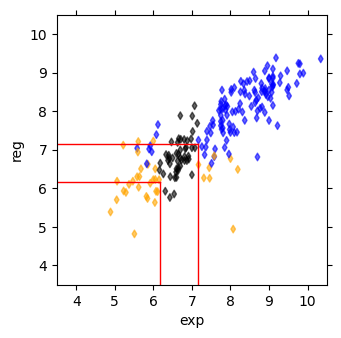

118 110
34 27
min 4.89
max 10.34


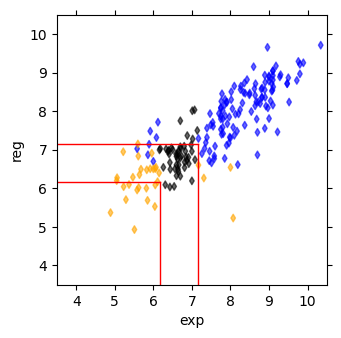

118 114
34 27
min 4.674686908721924
max 10.34


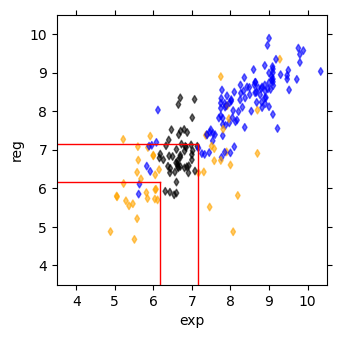

In [111]:
path = home+"/repositories/ai-DR/selectivity_models/models_C33_200/"
model = "models_D3"

method = "xgb"
save2png = "output_dir/D3_xgb.png"
df1 = plot_model(path, model, method, save2png)
binder_ratio(df1, 7.16)
nonbinder_ratio(df1, 6.16)

method = "rf"
save2png = "output_dir/D3_rf.png"
df2 = plot_model(path, model, method, save2png)
binder_ratio(df2, 7.16)
nonbinder_ratio(df2, 6.16)

method = "dnn"
save2png = "output_dir/D3_dnn.png"
df = plot_model(path, model, method, save2png)

min 4.27
max 10.4


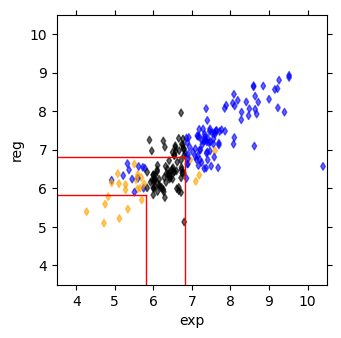

94 90
30 19
min 4.27
max 10.4


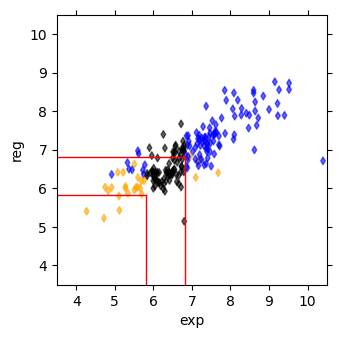

94 90
30 21
min 4.27
max 10.4


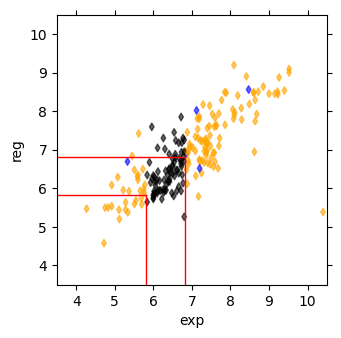

In [112]:
path = home+"/repositories/ai-DR/selectivity_models/models_C33_200/"
model = "models_D2"

method = "xgb"
save2png = "output_dir/D2_xgb.png"
df1 = plot_model(path, model, method, save2png)
binder_ratio(df1, 6.82)
nonbinder_ratio(df1, 5.82)

method = "rf"
save2png = "output_dir/D2_rf.png"
df2 = plot_model(path, model, method, save2png)
binder_ratio(df2, 6.82)
nonbinder_ratio(df2, 5.82)

method = "dnn"
save2png = "output_dir/D2_dnn.png"
df3 = plot_model(path, model, method, save2png)

# Consensus 

In [55]:
def get_consensus_reg(path, model):
    # Create an empty list to store the results for each model
    all_predictions = []

    # Read the predictions from each model (XGBoost, Random Forest, DNN)
    df1 = pd.read_csv(f"{path}/{model}/model_0/pred_reg_xgb_0.00/pred_splits_val0", sep="\t")
    df1 = df1[['compound', 'exp_mean', 'split_0']]
    df2 = pd.read_csv(f"{path}/{model}/model_0/pred_reg_rf_0.00/pred_splits_val0", sep="\t")
    df2 = df2[['compound', 'exp_mean', 'split_0']]
    df3 = pd.read_csv(f"{path}/{model}/model_0/pred_reg_dnn_0.00/pred_splits", sep="\t")
    df3 = df3[['compound', 'exp_mean', 'split_0']]

    # Rename the 'split_0' columns to 'xgb', 'rf', and 'dnn'
    df1.rename(columns={'split_0': 'xgb'}, inplace=True)
    df2.rename(columns={'split_0': 'rf'}, inplace=True)
    df3.rename(columns={'split_0': 'dnn'}, inplace=True)

    # Merge the data frames based on the common columns 'compound' and 'exp_mean'
    merged_df = pd.merge(df1, df2, on=['compound', 'exp_mean'], how='outer')
    merged_df = pd.merge(merged_df, df3, on=['compound', 'exp_mean'], how='outer')

    # Calculate consensus prediction as the average of xgb, rf, and dnn predictions
    merged_df["consensus"] = merged_df['xgb'] * 1/3 + merged_df["rf"] * 1/3 + merged_df["dnn"] * 1/3

    # Append the predictions for this iteration to the list
    all_predictions.append(merged_df[['compound', 'exp_mean', 'xgb', 'rf', 'dnn', 'consensus']])

    # Concatenate the results into one dataframe (only one run)
    final_predictions_df = pd.concat(all_predictions, ignore_index=True)

    return final_predictions_df


def get_consensus_class(path, model):
    # Create an empty list to store the results for each model
    all_predictions = []

    # Read the predictions from each model (XGBoost, Random Forest, DNN)
    df1 = pd.read_csv(f"{path}/{model}/model_0/pred_class_xgb_0.00/pred_splits_val_class0", sep="\t")
    df2 = pd.read_csv(f"{path}/{model}/model_0/pred_class_rf_0.00/pred_splits_val_class0", sep="\t")
    df3 = pd.read_csv(f"{path}/{model}/model_0/pred_class_dnn_0.00/pred_splits", sep="\t")

    # Rename the 'split_0' columns to 'xgb', 'rf', and 'dnn'
    df1.rename(columns={'pred_activity': 'xgb'}, inplace=True)
    df2.rename(columns={'pred_activity': 'rf'}, inplace=True)
    df3.rename(columns={'pred_activity': 'dnn'}, inplace=True)

    # Merge the data frames based on the common columns 'compound' and 'exp_mean'
    merged_df = pd.merge(df1, df2, on=['compound', 'exp_mean'], how='outer')
    merged_df = pd.merge(merged_df, df3, on=['compound', 'exp_mean'], how='outer')

    # Calculate consensus prediction as the average of xgb, rf, and dnn predictions
    merged_df["consensus"] = merged_df['xgb'] * 1/3 + merged_df["rf"] * 1/3 + merged_df["dnn"] * 1/3

    # Append the predictions for this iteration to the list
    all_predictions.append(merged_df[['compound', 'exp_mean', 'xgb', 'rf', 'dnn', 'consensus']])

    # Concatenate the results into one dataframe (only one run)
    final_predictions_df = pd.concat(all_predictions, ignore_index=True)
    final_predictions_df['consensus'] = (final_predictions_df['consensus'] > 0.5).astype(int)


    return final_predictions_df


def plot_model_consensus(path, model, save2png):
    # reformat plot sizes and boundaries based on models used
    if model == "models__ratio_D2D3":
        xy_min = -2.5
        xy_max = 3.5
        plot_size = 3 
        low_threshold = 0
    elif model == "models_D3":
        xy_min = 3.5
        xy_max = 10.5
        plot_size = 3 
        low_threshold = 6.16
    elif model == "models_D2":
        xy_min = 3.5
        xy_max = 10.5
        plot_size = 3 
        low_threshold = 5.82

    # get consensus dfs
    df_reg = get_consensus_reg(path, model)
    df_class = get_consensus_class(path, model)
    df_reg["reg"] = df_reg["consensus"]
    df_class["class"] = df_class["consensus"]

    # combine consensus dfs, like how it was done above for non-consensus dfs
    df = combine_reg_class_color(df_reg, df_class, low_threshold)
    plot_predictions(df, low_threshold, xy_min, xy_max, plot_size)
    plot_predictions(df, low_threshold, xy_min, xy_max, plot_size, save2png = save2png)
    return df

min 4.27
max 10.4


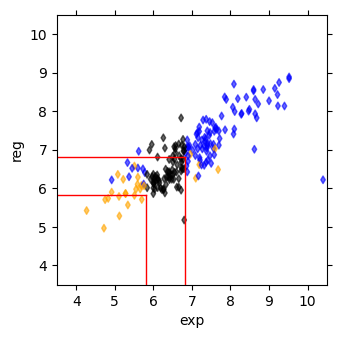

min 4.807463544209798
max 10.34


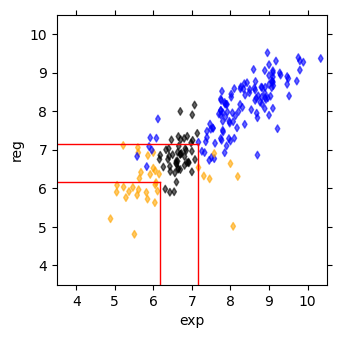

min -2.28
max 3.35


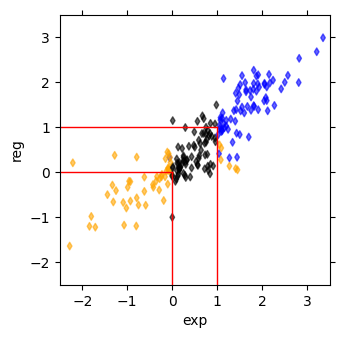

,compound,exp,reg,class,color
0,CHEMBL1223859,-2.28,-1.641207,0.0,orange
1,CHEMBL467768,1.14,1.074690,1.0,blue
2,CHEMBL4789472,0.10,0.294694,NaN,black
3,CHEMBL3759865,1.87,2.137468,1.0,blue
4,CHEMBL2024522,1.10,0.955127,1.0,blue
...,...,...,...,...,...
195,CHEMBL4845838,1.82,1.461311,1.0,blue
196,CHEMBL3234541,-0.19,-0.628719,0.0,orange
197,CHEMBL3084502,0.33,0.276837,NaN,black
198,CHEMBL1774543,0.01,0.097168,NaN,black


In [56]:
path = home+"/repositories/ai-DR/selectivity_models/models_C33_200/"
model = "models_D2"
save2png = "output_dir/D2_consensus.png"
plot_model_consensus(path, model, save2png)

model = "models_D3"
save2png = "output_dir/D3_consensus.png"
plot_model_consensus(path, model, save2png)

model = "models__ratio_D2D3"
save2png = "output_dir/D3_selective_consensus.png"
plot_model_consensus(path, model, save2png)